In [3]:
import sys
sys.path.extend(['./'])
from strategy import Strategy
from backtest import Bt
import matplotlib.pyplot as plt
from plot import get_plotly
from data import Data
import pandas as pd
import time
import talib

In [4]:
def OBV_SLOPE(data_OBV: pd.Series):
    obv_slope = talib.LINEARREG_SLOPE(data_OBV['OBV'], timeperiod=5)
    return pd.Series(obv_slope, index=data_OBV.index)

In [16]:
class CCI(Strategy):
    def __init__(self):
        self.data = Data().symbol_data(symbol=['AMD'])
        self.init_capital = 10000
        self.cci = self.indicator('CCI')

    def signal(self, index):

        if (self.cci['CCI'][index] > -100) & (self.cci['CCI'][index - 1] < -100) & (not self.long_position):
            #先將做空部位買回，在做多
            if self.short_position:
                self.close_position()
            self.buy(unit=1, stop_loss=0.1, stop_profit=0.1)
        if (self.cci['CCI'][index] < 100) & (self.cci['CCI'][index - 1] > 100) & (not self.short_position):
            if self.long_position:
                self.close_position()
            self.sell(unit=-1)   


class Test(Strategy):
    
    def __init__(self):
        self.data = Data().symbol_data(symbol=['AAPL'])
        self.data = self.data['2005':'2010']
        self.data.volality_5 = self.data.close.pct_change().rolling(5).std()
        self.data.volality_10 = self.data.close.pct_change().rolling(10).std()

        self.data.columns = [c.lower() for c in self.data.columns]
        self.init_capital = 100000
        self.obv = self.indicator('OBV')
        self.data['obv_slope'] = OBV_SLOPE(self.obv)
#         self.MV = self.data.

    def signal(self, index):
        
        if (self.data.volality_5[index] > self.data.volality_10[index-1]) & (self.data.volality_10[index-1] < self.data.volality_5[index-1]) & (self.data.obv_slope[index] > 0)& (self.position == 0):
            self.buy(0.99)
        if (self.data.volality_5[index] < self.data.volality_10[index-1]) & (self.data.volality_10[index-1] > self.data.volality_5[index-1]) & (self.data.obv_slope[index] < 0)& (self.position > 0):
            self.sell()

In [17]:
log, per = Bt(Test, commission=None).run()

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



-----------------------------|
sharpe ratio | 0.906 --------|
-----------------------------|
calarm ratio | 0.944 --------|
-----------------------------|


In [14]:
log.head()

BuyDate  BuyPrice  BuyUnits  CashPaying   SellDate  SellPrice  SellUnits  \
0 2005-01-28     16.14      6133    98986.62 2005-02-17      17.51      -6133   
1 2005-02-28     17.70      6063   107315.10 2005-03-07      17.34      -6063   
2 2005-03-29     15.40      6828   105151.20 2005-04-06      15.95      -6828   
3 2005-04-13     17.23      6318   108859.14 2005-04-19      15.49      -6318   
4 2005-05-20     15.91      6159    97989.69 2005-06-20      17.23      -6159   

   CashReceiving  KeepDay  profit(元)  報酬率(%)  累積報酬率(%)  MDD(%)     Equity  \
0      107388.83       20    8402.21   8.488     8.488   6.469  108402.21   
1      105132.42        7   -2182.68  -2.034     6.281   2.951  106219.53   
2      108906.60        8    3755.40   3.571    10.077   2.899  109974.93   
3       97865.82        6  -10993.32 -10.099    -1.040  10.434   98981.61   
4      106119.57       31    8129.88   8.297     7.171   6.370  107111.49   

   EquityReturn  EquityAccumulateReturn  
0      8.402210                   8.402  
1     -2.013501                   6.220  
2      3.535508                   9.975  
3     -9.996205                  -1.018  
4      8.213526                   7.111

In [18]:
per

年度總損益(元)  作多次數(次)  作空次數(次)  交易總次數(次)  勝率(%)  獲利因子   最大損失(元)  最大獲利(元)  \
2005   60885.04       13        0        13  69.23  3.26  -16259.0  17470.0   
2006   30355.61       11        0        11  54.55  1.79  -12467.0  23796.0   
2007   69834.38        9        0         9  66.67  3.36  -11671.0  34704.0   
2008  -50223.81       14        0        14  50.00  0.72 -128597.0  55282.0   
2009   68633.70       15        0        15  53.33  2.16  -21077.0  35693.0   
2010  216985.90       13        0        13  61.54  6.12  -18721.0  75358.0   

     個股年度報酬(%)  當年度報酬率(%)  平均交易報酬率(%)  累積年度報酬(%)  當年度權益報酬率(%)  權益累積年度報酬(%)  \
2005    122.00      61.58        4.74      61.58        60.89        60.89   
2006     17.49      19.05        1.73      92.36        18.87        91.24   
2007    129.70      36.91        4.10     163.35        36.52       161.08   
2008    -57.24     -19.55       -1.40     111.88       -19.24       110.85   
2009    145.28      32.88        2.19     181.55        32.55       179.48   
2010     50.99      78.60        6.05     402.85        77.64       396.47   

            權益  年化報酬率(%)  權益年化報酬率(%)  大盤年化報酬率(%)  
2005  160885.0     61.58       60.89        3.84  
2006  191241.0     38.69       38.29        8.62  
2007  261075.0     38.09       37.70        6.90  
2008  210851.0     20.65       20.50       -6.90  
2009  279485.0     23.00       22.82       -1.49  
2010  496471.0     30.89       30.61        0.76

/Users/apple/Documents/PythonProject/alphabt/plot.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:8682: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/apple/Documents/PythonProject/alphabt/backtest.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/apple/Documents/PythonProject/alphabt/plot.py:26: SettingWithCopyWarning:


A value is

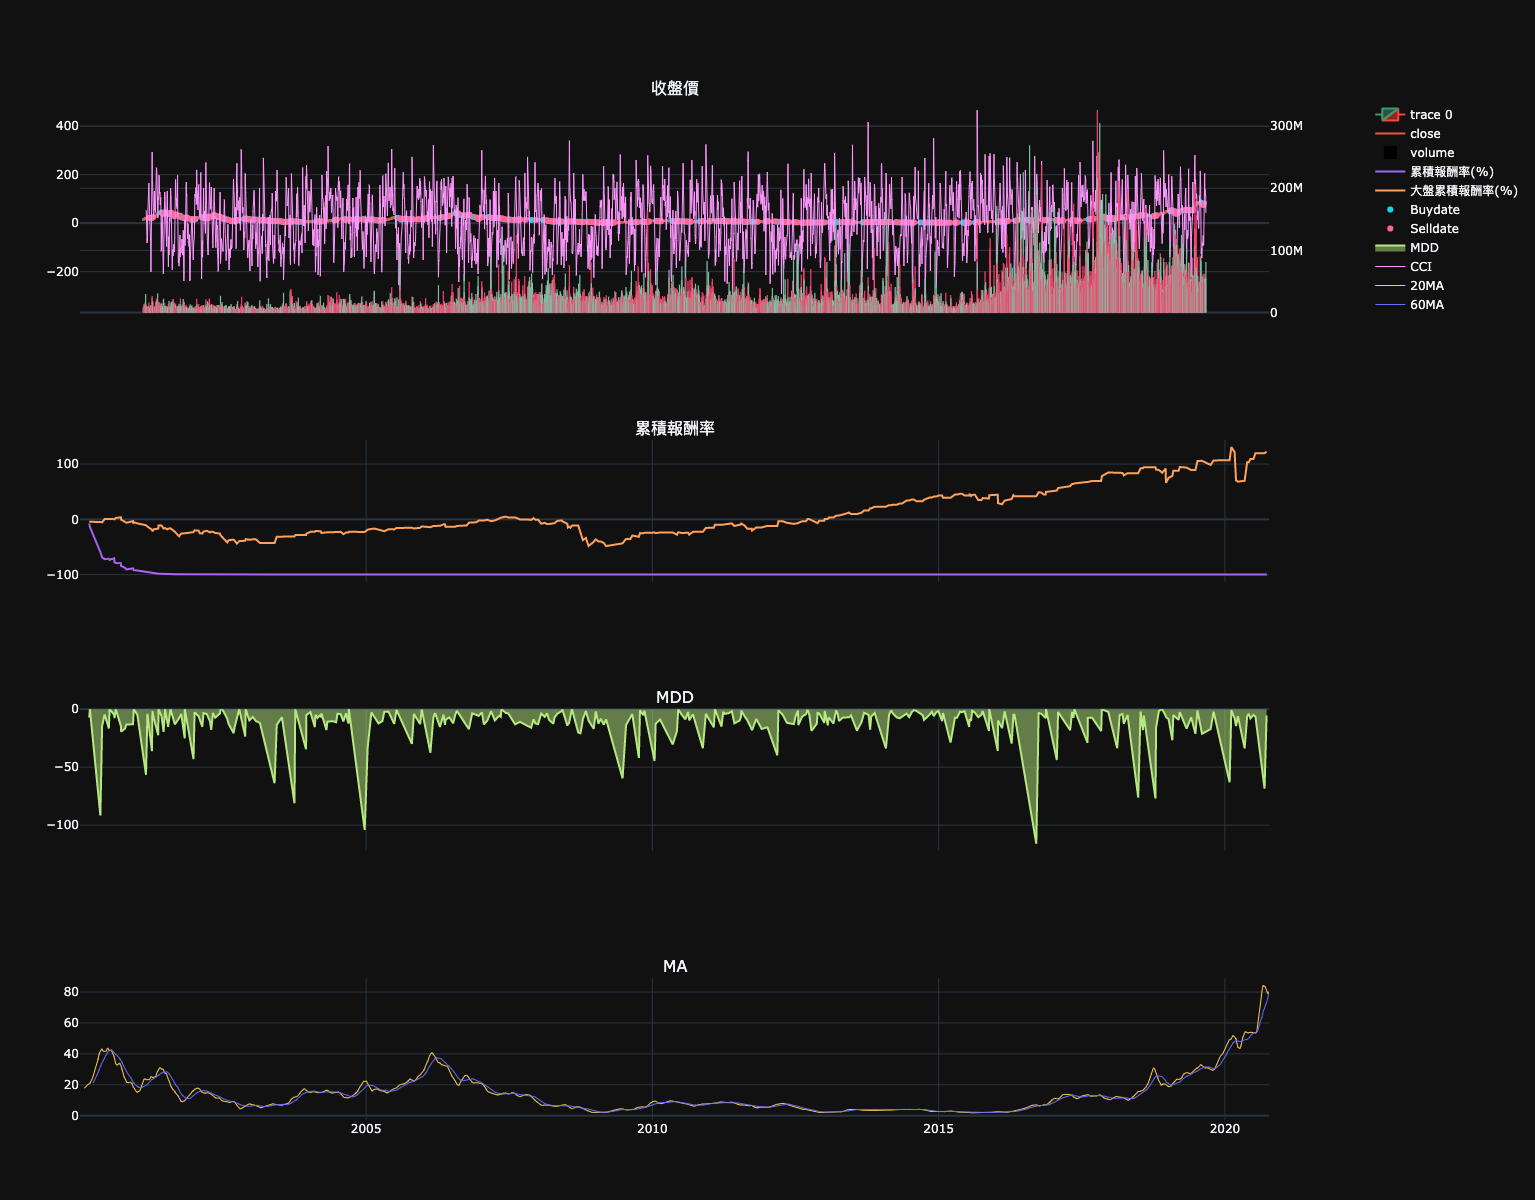

In [12]:
Bt(CCI).get_plot(subplot_technical_index=['MA'], overlap=['CCI'], sub_plot_param={'MA':[20, 60]}, overlap_param=None, log=log)
